# Dermanalyze

### Import Library

In [1]:
# Data Reading 
import os
import shutil

# Data Preprocessing 
import pandas as pd 
import numpy as np

# Data Analysis
import matplotlib.pyplot as plt 

# Data Modeling
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers, Model
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

### Download Dataset 

In [3]:
import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading skin-cancer-mnist-ham10000.zip to .\skin-cancer-mnist-ham10000


100%|██████████| 5.20G/5.20G [23:57<00:00, 3.88MB/s]  


### Data Exploration 

#### Train and Validation Set

In [2]:
image_dir = os.path.join(os.getcwd(), 'skin-cancer-mnist-ham10000')
os.listdir(image_dir)

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [3]:
train_val_df_raw = pd.read_csv(os.path.join(image_dir, "HAM10000_metadata.csv"))
train_val_df_raw.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
# show the number of rows and columns 
train_val_df_raw.shape

(10015, 7)

In [5]:
# view the characteristics of the data
train_val_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


 The `age` column has missing values, but it's not such an important feature that it can be ignored

In [6]:
print("Unique Lesion:\t", train_val_df_raw['lesion_id'].nunique()) 
print("Unique Image:\t", train_val_df_raw['image_id'].nunique())
print("Unique Image:\t", train_val_df_raw['dx'].unique()) # label names

Unique Lesion:	 7470
Unique Image:	 10015
Unique Image:	 ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


The number of images is more than the number of lesions, this indicates 1 lesion has more than 1 image

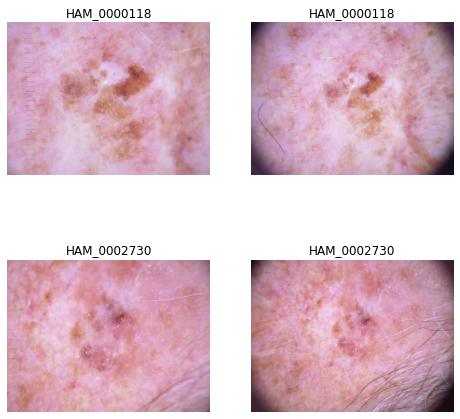

In [7]:
# plot images that have the same lesion_id
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(columns*rows):
    img = plt.imread(os.path.join(image_dir, "HAM10000_images_part_1", train_val_df_raw['image_id'][i]+".jpg"))
    fig.add_subplot(rows, columns, i+1)
    plt.title(train_val_df_raw['lesion_id'][i])
    plt.imshow(img)
    plt.axis("off")    
plt.show()

 The duplicate lesions have the same image

### Test Set

In [10]:
test_image_dir = os.path.join(os.getcwd(), "test-images")
os.listdir(test_image_dir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'c:\\Users\\Nur Hidayati\\OneDrive\\Documents\\Bangkit-2022\\Capstone Project\\test-images'

In [ ]:
test_df_raw = pd.read_csv(os.path.join(test_image_dir, "ISIC2018_Task3_Test_NatureMedicine_AI_Interaction_Benefit.csv"))
test_df_raw.head()

,image_id,interaction_modality,prob_m_mal,prob_m_dx_akiec,prob_m_dx_bcc,prob_m_dx_bkl,prob_m_dx_df,prob_m_dx_mel,prob_m_dx_nv,prob_m_dx_vasc,...,user_dx_without_interaction_mel,user_dx_without_interaction_nv,user_dx_without_interaction_vasc,user_dx_with_interaction_akiec,user_dx_with_interaction_bcc,user_dx_with_interaction_bkl,user_dx_with_interaction_df,user_dx_with_interaction_mel,user_dx_with_interaction_nv,user_dx_with_interaction_vasc
0,ISIC_0034524,Malignancy Probability (AI),"3,6112365E-07","3,90293E-08","8,117796E-08","1,230346E-06","6,8621403E-06","2,409164E-07","0,9999885","3,0752137E-06",...,0,0,0,0,0,0,0,0,1,0
1,ISIC_0034525,Malignancy Probability (AI),"0,00063954331927","4,6960016E-05","8,363065E-05","8,099651E-05","0,82006663","0,00050895265","0,17920908","3,744718E-06",...,0,1,0,0,0,0,0,0,1,0
2,ISIC_0034525,Multiclass Probabilities (Crowd),"0,00063954331927","4,6960016E-05","8,363065E-05","8,099651E-05","0,82006663","0,00050895265","0,17920908","3,744718E-06",...,0,0,0,0,0,0,0,0,1,0
3,ISIC_0034526,CBIR (AI),"0,03198014359805","0,01575451","0,00038216423","0,935222","0,00071165885","0,01584347","0,032083057","3,17123E-06",...,1,0,0,0,0,5,0,0,0,0
4,ISIC_0034526,Malignancy Probability (AI),"0,03198014359805","0,01575451","0,00038216423","0,935222","0,00071165885","0,01584347","0,032083057","3,17123E-06",...,2,0,0,0,0,2,0,2,0,0


An `image_id` can have more than one `interaction_modality`

In [ ]:
# show the number of rows and columns
test_df_raw.shape

(3762, 31)

In [ ]:
# view the characteristics of the data
test_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   image_id                           3762 non-null   object
 1   interaction_modality               3762 non-null   object
 2   prob_m_mal                         3762 non-null   object
 3   prob_m_dx_akiec                    3762 non-null   object
 4   prob_m_dx_bcc                      3762 non-null   object
 5   prob_m_dx_bkl                      3762 non-null   object
 6   prob_m_dx_df                       3762 non-null   object
 7   prob_m_dx_mel                      3762 non-null   object
 8   prob_m_dx_nv                       3762 non-null   object
 9   prob_m_dx_vasc                     3762 non-null   object
 10  prob_h_dx_akiec                    3762 non-null   object
 11  prob_h_dx_bcc                      3762 non-null   object
 12  prob_h

`prob_m_mal` to `prob_h_dx_vasc` features have object (string) data types, instead of float data types

In [ ]:
# view the number of `interaction_modality` used
test_df_raw[['image_id', 'interaction_modality']].groupby(['interaction_modality']).count()

,image_id
interaction_modality,
CBIR (AI),930
Malignancy Probability (AI),951
Multiclass Probabilities (AI),948
Multiclass Probabilities (Crowd),933


In [ ]:
# find out if the AI ​​and Crowd prediction results are the same in each `interaction_modality`
column_test_df = list(test_df_raw.columns)
column_test_df.remove('interaction_modality')
result = test_df_raw.groupby(column_test_df).count()
result.head(10)

interaction_modality
image_id     prob_m_mal       prob_m_dx_akiec prob_m_dx_bcc prob_m_dx_bkl prob_m_dx_df  prob_m_dx_mel prob_m_dx_nv prob_m_dx_vasc prob_h_dx_akiec prob_h_dx_bcc prob_h_dx_bkl prob_h_dx_df prob_h_dx_mel prob_h_dx_nv prob_h_dx_vasc user_dx_without_interaction_akiec user_dx_without_interaction_bcc user_dx_without_interaction_bkl user_dx_without_interaction_df user_dx_without_interaction_mel user_dx_without_interaction_nv user_dx_without_interaction_vasc user_dx_with_interaction_akiec user_dx_with_interaction_bcc user_dx_with_interaction_bkl user_dx_with_interaction_df user_dx_with_interaction_mel user_dx_with_interaction_nv user_dx_with_interaction_vasc                      
ISIC_0034524 3,6112365E-07    3,90293E-08     8,117796E-08  1,230346E-06  6,8621403E-06 2,409164E-07  0,9999885    3,0752137E-06  0,050632911     0,012658227   0,012658227   0,050632911  0,215189873   0,658227848  0              0                                 0                               1                               0                              0                               0                              0                                0                              0                            0                            0                           0                            1                           0                                                 1
ISIC_0034525 0,00063954331927 4,6960016E-05   8,363065E-05  8,099651E-05  0,82006663    0,00050895265 0,17920908   3,744718E-06   0,037037037     0             0,024691358   0,160493827  0,037037037   0,728395061  0              0                                 0                               0                               0                              0                               1                              0                                0                              0                            0                            0                           0                            1                           0                                                 1
                                                                                                                                                                                                                                                                                                                                       1                              0                               0                              0                                0                              0                            0                            0                           0                            1                           0                                                 1
ISIC_0034526 0,03198014359805 0,01575451      0,00038216423 0,935222      0,00071165885 0,01584347    0,032083057  3,17123E-06    0,116279069     0,104651162   0,360465116   0,011627906  0,360465116   0,023255813  0              0                                 0                               4                               0                              1                               0                              0                                0                              0                            5                            0                           0                            0                           0                                                 1
                                                                                                                                                                                                                                                                       1                               1                               0                              2                               0                              0                                0                              0                            2                            0                           2       

The AI ​​and Crowd prediction results are not same in each `interaction_modality`, especially on Crowd prediction

In [ ]:
# view the number of `interaction_modality` used in each image 
id_result = test_df_raw[['image_id', 'interaction_modality']].groupby(['image_id']).count()
id_result.reset_index(inplace=True)
id_result.head()

,image_id,interaction_modality
0,ISIC_0034524,1
1,ISIC_0034525,2
2,ISIC_0034526,3
3,ISIC_0034527,3
4,ISIC_0034528,1


In [ ]:
# find out if the AI ​​prediction results are the same in each `interaction_modality`
grouped_column = ['image_id', 'prob_m_mal', 'prob_m_dx_akiec', 'prob_m_dx_bcc', 'prob_m_dx_bkl', 'prob_m_dx_df', 'prob_m_dx_mel', 'prob_m_dx_nv', 'prob_m_dx_vasc', 
                  'prob_h_dx_akiec', 'prob_h_dx_bcc', 'prob_h_dx_bkl', 'prob_h_dx_df', 'prob_h_dx_mel', 'prob_h_dx_nv', 'prob_h_dx_vasc']
selected_column = grouped_column.copy()
selected_column.append('interaction_modality')
ai_result = test_df_raw[selected_column].groupby(grouped_column).count()
ai_result.rename(columns = {'interaction_modality':'ai_interaction_modality'}, inplace = True)
ai_result.reset_index(inplace=True)
ai_result.head()

,image_id,prob_m_mal,prob_m_dx_akiec,prob_m_dx_bcc,prob_m_dx_bkl,prob_m_dx_df,prob_m_dx_mel,prob_m_dx_nv,prob_m_dx_vasc,prob_h_dx_akiec,prob_h_dx_bcc,prob_h_dx_bkl,prob_h_dx_df,prob_h_dx_mel,prob_h_dx_nv,prob_h_dx_vasc,ai_interaction_modality
0,ISIC_0034524,"3,6112365E-07","3,90293E-08","8,117796E-08","1,230346E-06","6,8621403E-06","2,409164E-07","0,9999885","3,0752137E-06","0,050632911","0,012658227","0,012658227","0,050632911","0,215189873","0,658227848",0,1
1,ISIC_0034525,"0,00063954331927","4,6960016E-05","8,363065E-05","8,099651E-05","0,82006663","0,00050895265","0,17920908","3,744718E-06","0,037037037",0,"0,024691358","0,160493827","0,037037037","0,728395061",0,2
2,ISIC_0034526,"0,03198014359805","0,01575451","0,00038216423","0,935222","0,00071165885","0,01584347","0,032083057","3,17123E-06","0,116279069","0,104651162","0,360465116","0,011627906","0,360465116","0,023255813",0,3
3,ISIC_0034527,"0,0615372871689","4,2386528E-06","0,00018744147","0,006125812","0,010619301","0,061345607","0,9192848","0,00243272","0,011235955","0,011235955","0,202247191",0,"0,224719101","0,528089887",0,3
4,ISIC_0034528,"0,00785617555084","0,0052051246","9,795326E-05","0,2707644","0,052205835","0,0025530977","0,6689553","0,00021825725","0,014084507",0,"0,394366197",0,"0,042253521","0,549295774",0,1


In [ ]:
# compare the number of `interaction_modality` used in each image and the AI ​​prediction results in each `interaction_modality`
id_ai_result = pd.concat([id_result, ai_result['ai_interaction_modality']], axis=1)
print(id_ai_result.loc[id_ai_result['interaction_modality'] != id_ai_result['ai_interaction_modality']])

Empty DataFrame
Columns: [image_id, interaction_modality, ai_interaction_modality]
Index: []


The AI ​​prediction results are same in each `interaction_modality`

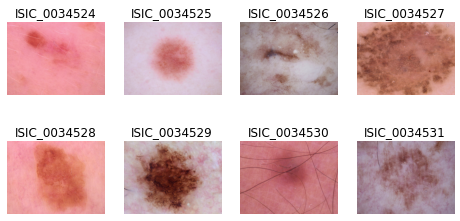

In [ ]:
# sampling
fig = plt.figure(figsize=(8, 4))
columns = 4
rows = 2
j = 0
for i in range(columns*rows):
    img = plt.imread(os.path.join(test_image_dir, "ISIC2018_Task3_Test_Images", test_df_raw['image_id'][j]+".jpg"))
    fig.add_subplot(rows, columns, i+1)
    plt.title(test_df_raw['image_id'][j])
    plt.imshow(img)
    plt.axis("off")
    id = test_df_raw['image_id'][j]
    while id == test_df_raw['image_id'][j]: j+=1
plt.show()

### Data Preparation

#### Train and Validation Set

##### Feature Selection

In [8]:
# drop unimportant column
train_val_df = train_val_df_raw.drop(columns=['dx_type', 'age', 'sex', 'localization'])
train_val_df.head()

,lesion_id,image_id,dx
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


##### Drop Duplicates

In [9]:
# drop duplicate lesions to avoid validation having the same image as train 
train_val_df = train_val_df.drop_duplicates(subset="lesion_id", keep="first", ignore_index=True)
train_val_df.head()

,lesion_id,image_id,dx
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0002730,ISIC_0026769,bkl
2,HAM_0001466,ISIC_0031633,bkl
3,HAM_0002761,ISIC_0029176,bkl
4,HAM_0005132,ISIC_0025837,bkl


##### Split Train and Validation Set

In [10]:
# split into 80% train and 20% val, stratification by the label(`dx`)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, shuffle=True, stratify=train_val_df['dx'])

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [11]:
print("Data distibution:")
print("\tAll\tTrain\tVal")
dict_train_val_df = dict(train_val_df['dx'].value_counts())
print("\n".join("{}\t{}\t{}\t{}".format(i, x, y, z) for i, x, y, z in zip(
    dict_train_val_df.keys(),
    dict_train_val_df.values(),
    train_df['dx'].value_counts(), 
    val_df['dx'].value_counts())))

Data distibution:
	All	Train	Val
nv	5403	4323	1080
bkl	727	582	145
mel	614	491	123
bcc	327	262	65
akiec	228	182	46
vasc	98	78	20
df	73	58	15


##### Create Train and Validation Directory

In [12]:
# define dataset directory
base_dir = os.path.join(os.getcwd(), "lesions")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
labels = train_val_df['dx'].unique()

In [16]:
#create dataset directory
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(val_dir)
for label in labels:
    os.mkdir(os.path.join(train_dir, label))
    os.mkdir(os.path.join(val_dir, label))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'c:\\Users\\Nur Hidayati\\OneDrive\\Documents\\Bangkit-2022\\Capstone Project\\lesions'

##### Copy Images to Train and Validation Directory

In [66]:
def copy_images(dataframe, src_dir, dst_dir):
    src_dir1 = os.path.join(image_dir, "HAM10000_images_part_1")
    src_dir2 = os.path.join(image_dir, "HAM10000_images_part_2")
    
    list_src_dir1 = os.listdir(src_dir1)
    list_src_dir2 = os.listdir(src_dir2)

    for _, row in dataframe.iterrows(): 
        filename = row['image_id'] + ".jpg"
        label = row['dx']
        if filename in list_src_dir1:
            src = os.path.join(src_dir1, filename)
            dst = os.path.join(dst_dir, label, filename)
            # print("{}\n{}".format(src, dst))
            shutil.copyfile(src, dst)
        elif filename in list_src_dir2:
            src = os.path.join(src_dir2, filename)
            dst = os.path.join(dst_dir, label, filename)            
            # print("{}\n{}".format(src, dst))
            shutil.copyfile(src, dst)

copy_images(train_df, image_dir, train_dir)
copy_images(val_df, image_dir, val_dir)

In [13]:
print(len(os.listdir(os.path.join(train_dir, 'akiec'))))
print(len(os.listdir(os.path.join(train_dir, 'bcc'))))
print(len(os.listdir(os.path.join(train_dir, 'bkl'))))
print(len(os.listdir(os.path.join(train_dir, 'df'))))
print(len(os.listdir(os.path.join(train_dir, 'mel'))))
print(len(os.listdir(os.path.join(train_dir, 'nv'))))
print(len(os.listdir(os.path.join(train_dir, 'vasc'))))

182
262
582
58
491
4323
78


In [14]:
print(len(os.listdir(os.path.join(val_dir, 'akiec'))))
print(len(os.listdir(os.path.join(val_dir, 'bcc'))))
print(len(os.listdir(os.path.join(val_dir, 'bkl'))))
print(len(os.listdir(os.path.join(val_dir, 'df'))))
print(len(os.listdir(os.path.join(val_dir, 'mel'))))
print(len(os.listdir(os.path.join(val_dir, 'nv'))))
print(len(os.listdir(os.path.join(val_dir, 'vasc'))))

46
65
145
15
123
1080
20


In [69]:
class_labels = ['akiec','bcc','bkl','df','mel','vasc']

for item in class_labels:
    aug_dir = os.path.join(os.getcwd(), 'aug_dir')
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)
    
    class_path = os.path.join(train_dir, item)
    img_list = os.listdir(class_path)
    
    for filename in img_list:
        src = os.path.join(class_path, filename)
        dst = os.path.join(img_dir, filename)
        shutil.copyfile(src, dst)

    aug_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40, 
            width_shift_range=0.2, 
            height_shift_range=0.2,
            # shear_range=0.2, 
            zoom_range=0.2, 
            horizontal_flip=True, 
            fill_mode='nearest')

    batch_size = 50

    aug_datagen_generator = aug_datagen.flow_from_directory(aug_dir,
                                                            save_to_dir=class_path,
                                                            save_format='jpg',
                                                            target_size=(224,224),
                                                            batch_size=batch_size)

    num_aug_img = 6000
    num_folder = len(os.listdir(img_dir))
    num_batch = int(np.ceil((num_aug_img - num_folder) / batch_size))

    for i in range(0,num_batch):
        imgs, labels = next(aug_datagen_generator)
            
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 182 images belonging to 1 classes.
Found 262 images belonging to 1 classes.
Found 582 images belonging to 1 classes.
Found 58 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 78 images belonging to 1 classes.


In [19]:
print(len(os.listdir(os.path.join(train_dir, 'akiec'))))
print(len(os.listdir(os.path.join(train_dir, 'bcc'))))
print(len(os.listdir(os.path.join(train_dir, 'bkl'))))
print(len(os.listdir(os.path.join(train_dir, 'df'))))
print(len(os.listdir(os.path.join(train_dir, 'mel'))))
print(len(os.listdir(os.path.join(train_dir, 'nv'))))
print(len(os.listdir(os.path.join(train_dir, 'vasc'))))

182
262
582
58
491
4323
78


### Test Set

#### Feature Selection

In [ ]:
# drop unimportant column
dropped_column = ['interaction_modality', 'prob_m_mal', 'user_dx_without_interaction_akiec', 'user_dx_without_interaction_bcc', 'user_dx_without_interaction_bkl', 
                  'user_dx_without_interaction_df', 'user_dx_without_interaction_mel', 'user_dx_without_interaction_nv', 'user_dx_without_interaction_vasc', 
                  'user_dx_with_interaction_akiec', 'user_dx_with_interaction_bcc', 'user_dx_with_interaction_bkl', 'user_dx_with_interaction_df', 
                  'user_dx_with_interaction_mel', 'user_dx_with_interaction_nv', 'user_dx_with_interaction_vasc']
test_df = test_df_raw.drop(columns=dropped_column)
test_df.head()

,image_id,prob_m_dx_akiec,prob_m_dx_bcc,prob_m_dx_bkl,prob_m_dx_df,prob_m_dx_mel,prob_m_dx_nv,prob_m_dx_vasc,prob_h_dx_akiec,prob_h_dx_bcc,prob_h_dx_bkl,prob_h_dx_df,prob_h_dx_mel,prob_h_dx_nv,prob_h_dx_vasc
0,ISIC_0034524,"3,90293E-08","8,117796E-08","1,230346E-06","6,8621403E-06","2,409164E-07","0,9999885","3,0752137E-06","0,050632911","0,012658227","0,012658227","0,050632911","0,215189873","0,658227848",0
1,ISIC_0034525,"4,6960016E-05","8,363065E-05","8,099651E-05","0,82006663","0,00050895265","0,17920908","3,744718E-06","0,037037037",0,"0,024691358","0,160493827","0,037037037","0,728395061",0
2,ISIC_0034525,"4,6960016E-05","8,363065E-05","8,099651E-05","0,82006663","0,00050895265","0,17920908","3,744718E-06","0,037037037",0,"0,024691358","0,160493827","0,037037037","0,728395061",0
3,ISIC_0034526,"0,01575451","0,00038216423","0,935222","0,00071165885","0,01584347","0,032083057","3,17123E-06","0,116279069","0,104651162","0,360465116","0,011627906","0,360465116","0,023255813",0
4,ISIC_0034526,"0,01575451","0,00038216423","0,935222","0,00071165885","0,01584347","0,032083057","3,17123E-06","0,116279069","0,104651162","0,360465116","0,011627906","0,360465116","0,023255813",0


#### Drop Duplicates

In [ ]:
# drop duplicate (follow AI predictions)
test_df = test_df.drop_duplicates(subset="image_id", keep="first", ignore_index=True)
test_df.head()

,image_id,prob_m_dx_akiec,prob_m_dx_bcc,prob_m_dx_bkl,prob_m_dx_df,prob_m_dx_mel,prob_m_dx_nv,prob_m_dx_vasc,prob_h_dx_akiec,prob_h_dx_bcc,prob_h_dx_bkl,prob_h_dx_df,prob_h_dx_mel,prob_h_dx_nv,prob_h_dx_vasc
0,ISIC_0034524,"3,90293E-08","8,117796E-08","1,230346E-06","6,8621403E-06","2,409164E-07","0,9999885","3,0752137E-06","0,050632911","0,012658227","0,012658227","0,050632911","0,215189873","0,658227848",0
1,ISIC_0034525,"4,6960016E-05","8,363065E-05","8,099651E-05","0,82006663","0,00050895265","0,17920908","3,744718E-06","0,037037037",0,"0,024691358","0,160493827","0,037037037","0,728395061",0
2,ISIC_0034526,"0,01575451","0,00038216423","0,935222","0,00071165885","0,01584347","0,032083057","3,17123E-06","0,116279069","0,104651162","0,360465116","0,011627906","0,360465116","0,023255813",0
3,ISIC_0034527,"4,2386528E-06","0,00018744147","0,006125812","0,010619301","0,061345607","0,9192848","0,00243272","0,011235955","0,011235955","0,202247191",0,"0,224719101","0,528089887",0
4,ISIC_0034528,"0,0052051246","9,795326E-05","0,2707644","0,052205835","0,0025530977","0,6689553","0,00021825725","0,014084507",0,"0,394366197",0,"0,042253521","0,549295774",0


#### Change Data Types

In [ ]:
list_test_df = list(test_df.columns)
for column in list_test_df[1:]:
    test_df[column] = pd.to_numeric(test_df[column].apply(lambda x: re.sub(',', '.', str(x))))
test_df.head()

,image_id,prob_m_dx_akiec,prob_m_dx_bcc,prob_m_dx_bkl,prob_m_dx_df,prob_m_dx_mel,prob_m_dx_nv,prob_m_dx_vasc,prob_h_dx_akiec,prob_h_dx_bcc,prob_h_dx_bkl,prob_h_dx_df,prob_h_dx_mel,prob_h_dx_nv,prob_h_dx_vasc
0,ISIC_0034524,3.902930e-08,8.117796e-08,0.000001,0.000007,2.409164e-07,0.999988,0.000003,0.050633,0.012658,0.012658,0.050633,0.215190,0.658228,0.0
1,ISIC_0034525,4.696002e-05,8.363065e-05,0.000081,0.820067,5.089527e-04,0.179209,0.000004,0.037037,0.000000,0.024691,0.160494,0.037037,0.728395,0.0
2,ISIC_0034526,1.575451e-02,3.821642e-04,0.935222,0.000712,1.584347e-02,0.032083,0.000003,0.116279,0.104651,0.360465,0.011628,0.360465,0.023256,0.0
3,ISIC_0034527,4.238653e-06,1.874415e-04,0.006126,0.010619,6.134561e-02,0.919285,0.002433,0.011236,0.011236,0.202247,0.000000,0.224719,0.528090,0.0
4,ISIC_0034528,5.205125e-03,9.795326e-05,0.270764,0.052206,2.553098e-03,0.668955,0.000218,0.014085,0.000000,0.394366,0.000000,0.042254,0.549296,0.0


In [ ]:
# test_df = test_df.set_index('image_id')

In [ ]:
m_test_df = test_df[['image_id',
 'prob_m_dx_akiec',
 'prob_m_dx_bcc',
 'prob_m_dx_bkl',
 'prob_m_dx_df',
 'prob_m_dx_mel',
 'prob_m_dx_nv',
 'prob_m_dx_vasc']].set_index('image_id')
m_test_df.head()

,prob_m_dx_akiec,prob_m_dx_bcc,prob_m_dx_bkl,prob_m_dx_df,prob_m_dx_mel,prob_m_dx_nv,prob_m_dx_vasc
image_id,,,,,,,
ISIC_0034524,3.902930e-08,8.117796e-08,0.000001,0.000007,2.409164e-07,0.999988,0.000003
ISIC_0034525,4.696002e-05,8.363065e-05,0.000081,0.820067,5.089527e-04,0.179209,0.000004
ISIC_0034526,1.575451e-02,3.821642e-04,0.935222,0.000712,1.584347e-02,0.032083,0.000003
ISIC_0034527,4.238653e-06,1.874415e-04,0.006126,0.010619,6.134561e-02,0.919285,0.002433
ISIC_0034528,5.205125e-03,9.795326e-05,0.270764,0.052206,2.553098e-03,0.668955,0.000218


In [ ]:
max_m = m_test_df.idxmax(axis=1)
max_m

image_id
ISIC_0034524       prob_m_dx_nv
ISIC_0034525       prob_m_dx_df
ISIC_0034526      prob_m_dx_bkl
ISIC_0034527       prob_m_dx_nv
ISIC_0034528       prob_m_dx_nv
                     ...       
ISIC_0036060      prob_m_dx_bkl
ISIC_0036061       prob_m_dx_nv
ISIC_0036062    prob_m_dx_akiec
ISIC_0036063      prob_m_dx_bkl
ISIC_0036064      prob_m_dx_mel
Length: 1412, dtype: object

In [ ]:
h_test_df = test_df[['image_id',
 'prob_h_dx_akiec',
 'prob_h_dx_bcc',
 'prob_h_dx_bkl',
 'prob_h_dx_df',
 'prob_h_dx_mel',
 'prob_h_dx_nv',
 'prob_h_dx_vasc'
]].set_index('image_id')
h_test_df.head()

,prob_h_dx_akiec,prob_h_dx_bcc,prob_h_dx_bkl,prob_h_dx_df,prob_h_dx_mel,prob_h_dx_nv,prob_h_dx_vasc
image_id,,,,,,,
ISIC_0034524,0.050633,0.012658,0.012658,0.050633,0.215190,0.658228,0.0
ISIC_0034525,0.037037,0.000000,0.024691,0.160494,0.037037,0.728395,0.0
ISIC_0034526,0.116279,0.104651,0.360465,0.011628,0.360465,0.023256,0.0
ISIC_0034527,0.011236,0.011236,0.202247,0.000000,0.224719,0.528090,0.0
ISIC_0034528,0.014085,0.000000,0.394366,0.000000,0.042254,0.549296,0.0


In [ ]:
max_h = h_test_df.idxmax(axis=1)
max_h

image_id
ISIC_0034524       prob_h_dx_nv
ISIC_0034525       prob_h_dx_nv
ISIC_0034526      prob_h_dx_bkl
ISIC_0034527       prob_h_dx_nv
ISIC_0034528       prob_h_dx_nv
                     ...       
ISIC_0036060      prob_h_dx_bkl
ISIC_0036061       prob_h_dx_nv
ISIC_0036062    prob_h_dx_akiec
ISIC_0036063      prob_h_dx_bkl
ISIC_0036064      prob_h_dx_bcc
Length: 1412, dtype: object

In [ ]:
max_m.compare(max_h).head(25)

,self,other
image_id,,
ISIC_0034524,prob_m_dx_nv,prob_h_dx_nv
ISIC_0034525,prob_m_dx_df,prob_h_dx_nv
ISIC_0034526,prob_m_dx_bkl,prob_h_dx_bkl
ISIC_0034527,prob_m_dx_nv,prob_h_dx_nv
ISIC_0034528,prob_m_dx_nv,prob_h_dx_nv
ISIC_0034529,prob_m_dx_mel,prob_h_dx_mel
ISIC_0034530,prob_m_dx_nv,prob_h_dx_df
ISIC_0034531,prob_m_dx_bkl,prob_h_dx_bkl
ISIC_0034533,prob_m_dx_nv,prob_h_dx_nv


In [ ]:
list(test_df.columns)

['image_id',
 'prob_m_dx_akiec',
 'prob_m_dx_bcc',
 'prob_m_dx_bkl',
 'prob_m_dx_df',
 'prob_m_dx_mel',
 'prob_m_dx_nv',
 'prob_m_dx_vasc',
 'prob_h_dx_akiec',
 'prob_h_dx_bcc',
 'prob_h_dx_bkl',
 'prob_h_dx_df',
 'prob_h_dx_mel',
 'prob_h_dx_nv',
 'prob_h_dx_vasc']

#### Create Test Directory

In [ ]:
test_dir = os.path.join(base_dir, "test")

In [ ]:
os.mkdir(test_dir)

FileNotFoundError: ignored

### Data Augmentation

In [15]:
# set variable
train_len = train_df.shape[0]
val_len = val_df.shape[0]
batch_size = 10

In [16]:
train_datagen = ImageDataGenerator( 
      rescale=1./255,
      rotation_range=40, 
      width_shift_range=0.2, 
      height_shift_range=0.2,
    #   shear_range=0.2, 
      zoom_range=0.2, 
      horizontal_flip=True, 
      fill_mode='nearest') 

# initialize validation image data generator
val_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224),  
        batch_size=20,
        class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 5976 images belonging to 7 classes.
Found 1494 images belonging to 7 classes.


In [18]:
pre_trained_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

175

In [19]:
pre_trained_model.trainable = True

In [20]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pre_trained_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [21]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [23]:
len(pre_trained_model.trainable_variables)

66

In [34]:
last_layer = pre_trained_model.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 7, 7, 2048)


In [35]:
head_model = pre_trained_model.output
head_model = Flatten()(head_model)
head_model = Dense(1024, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(7, activation='softmax')(head_model)

model = Model(pre_trained_model.input, head_model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [36]:
# Set the training parameters
model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [48]:
class myCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 80 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') >= 0.8):
      
      # Stop if threshold is met
      print("\nAccuracy is greater than or equals to 0.8 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [54]:
# Train the model
# initial_epochs = 10
# fine_tune_epochs = 10
# total_epochs =  initial_epochs + fine_tune_epochs

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    verbose=2,
                    steps_per_epoch = 100,
                    validation_steps = 50)

Epoch 1/20


TypeError: 'NoneType' object is not callable

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

KeyError: 'accuracy'